In [87]:
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import random
import transformers
from transformers import AutoModel, BertTokenizerFast, DistilBertTokenizer, DistilBertModel
from torchinfo import summary
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [88]:
# We have prepared a chitchat dataset with 5 labels
df = pd.read_csv("./data/intents.csv")
df.head()
print(df['Label'].value_counts())

# Converting the labels into encodings
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
df.head()
# check class distribution
df['Label_Encoded'].value_counts(normalize = True)

# In this example we have used all the utterances for training purpose
train_text, train_labels = df['Text'], df['Label_Encoded']

Genre       297
Question     54
Time         47
End          18
Start        18
Rating        9
Cast          7
Name: Label, dtype: int64


In [89]:
# # Load the BERT tokenizer
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# # Import BERT-base pretrained model
# bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


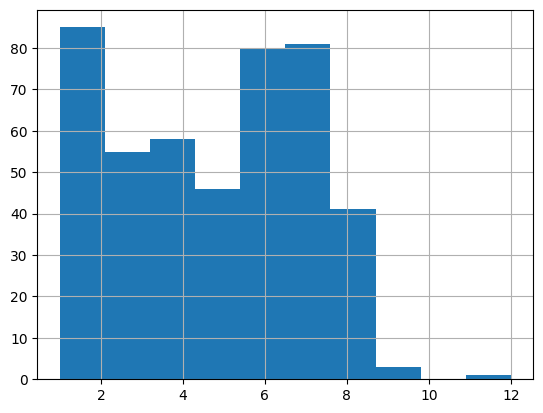

In [90]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)

max_seq_len = 9


In [91]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/Users/mridulmahesh/.local/share/virtualenvs/Project2_latest_version-9wTJLeyD/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [92]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [93]:
#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [94]:
class BERT_Arch(nn.Module):
   def __init__(self, bert):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,7)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)
      return x

In [95]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Arch(bert)
# push the model to GPU
# model = model.to(device)
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           1,799
├─LogSoftmax: 1-7                                       --
Total 

In [96]:
# define the optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
# print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

# empty lists to store training and validation loss of each epoch
train_losses=[]
# number of training epochs
epochs = 200
# We can also use learning rate scheduler to achieve better results
lr_sch = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [102]:
# function to train the model
def train():
  
    model.train()
    total_loss = 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
        # if step % 50 == 0 and not step == 0:
        # print(f'Batch {step}  of  {len(train_dataloader)}.')
        # push the batch to gpu
        # batch = [r.to(device) for r in batch] 
        sent_id, mask, labels = batch
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        # print(preds, labels)
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # clear calculated gradients
        optimizer.zero_grad()

        # We are not using learning rate scheduler as of now
        # lr_sch.step()
        # model predictions are stored on GPU. So, push it to CPU
        # preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds.detach().numpy())
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [103]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 200

Training Loss: 0.081

 Epoch 2 / 200

Training Loss: 0.019

 Epoch 3 / 200

Training Loss: 0.068

 Epoch 4 / 200

Training Loss: 0.027

 Epoch 5 / 200

Training Loss: 0.134

 Epoch 6 / 200

Training Loss: 0.031

 Epoch 7 / 200

Training Loss: 0.063

 Epoch 8 / 200

Training Loss: 0.043

 Epoch 9 / 200

Training Loss: 0.035

 Epoch 10 / 200

Training Loss: 0.047

 Epoch 11 / 200

Training Loss: 0.022

 Epoch 12 / 200

Training Loss: 0.040

 Epoch 13 / 200

Training Loss: 0.029

 Epoch 14 / 200

Training Loss: 0.054

 Epoch 15 / 200

Training Loss: 0.032

 Epoch 16 / 200

Training Loss: 0.060

 Epoch 17 / 200

Training Loss: 0.021

 Epoch 18 / 200

Training Loss: 0.028

 Epoch 19 / 200

Training Loss: 0.030

 Epoch 20 / 200

Training Loss: 0.125

 Epoch 21 / 200

Training Loss: 0.012

 Epoch 22 / 200

Training Loss: 0.041

 Epoch 23 / 200

Training Loss: 0.057

 Epoch 24 / 200

Training Loss: 0.054

 Epoch 25 / 200

Training Loss: 0.013

 Epoch 26 / 200

Training Loss: 0

In [113]:
def get_prediction(str):
    str = re.sub(r'[^a-zA-Z ]+', '', str)
    test_text = [str]
    model.eval()

    tokens_test_data = tokenizer(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
    )
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    test_mask = torch.tensor(tokens_test_data['attention_mask'])

    preds = model(test_seq, test_mask)
    preds = preds.detach().numpy()
    preds = np.argmax(preds, axis = 1)
    print('Intent Identified: ', le.inverse_transform(preds)[0])
    return le.inverse_transform(preds)[0]

def get_response(message): 
  intent = get_prediction(message)
#   for i in data['intents']: 
#     if i["tag"] == intent:
#       result = random.choice(i["responses"])
#       break
  print(f"Response : {'hello'}")
  return "Intent: "+ intent + '\n' + "Response: " #+ result

In [114]:
get_response("hello")

/Users/mridulmahesh/.local/share/virtualenvs/Project2_latest_version-9wTJLeyD/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


ValueError: y should be a 1d array, got an array of shape () instead.